In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import os
import glob
from tqdm.notebook import tqdm
from IPython.display import HTML, Image as ipython_image
from functools import partial
import pickle
import gc
# From resnetvideo
from torchvision.models.video.resnet import Bottleneck, BasicBlock, Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D
from typing import Any, Callable, List, Optional, Sequence, Tuple, Type, Union
from torch import Tensor


import matplotlib.pylab
matplotlib.pylab.rcParams['figure.dpi'] = 200

# Video analysis

I've simulated video data of a blob moving across a space of 128 x 128px (yay for powers of 2 this time). 

The blob is itself just an evaluation of a 2d gaussian kernel in the image space (which is a function of distance from center, a radius parameter, and a probability value for the center of the blob)

Each frame the effect of the blob is to sample from a Bernoulli distribution at every pixel, with probabilty given by the blob's values over the image space. In the end, we obtain a layer of what I'll call "claims" resulting from the movement of the blob, where each pixel in the image has values `{0, 1, ..., n_frames}`. Intuitively, more claims are generated closer to the center of the blob as it moves across the space.

In [2]:
VIDEO_DIR = 'simvid'

def sort_folders(folders, split_idx):
    idx = [int(x.split("_")[split_idx]) for x in folders]
    folders = [x for _, x in sorted(zip(idx, folders))]
    idx.sort()
    return folders, idx

video_dirs, video_idx = sort_folders(os.listdir(VIDEO_DIR), 1)


In [3]:
random.seed(123)

file_df = pd.DataFrame({
    "video_no": video_idx,
    "video_dirs": video_dirs,
    "train": random.choices([0, 1], weights = [0.2, 0.8], k=len(video_dirs))
})

file_df.head()

,video_no,video_dirs,train
0,0,blob_0_direction141.5_speed0.4_x89.0_y89.0_rad...,0
1,1,blob_1_direction-154.0_speed2.5_x68.0_y26.0_ra...,0
2,2,blob_2_direction-196.7_speed1.4_x65.0_y122.0_r...,1
3,3,blob_3_direction36.9_speed3.2_x95.0_y40.0_radi...,0
4,4,blob_4_direction158.0_speed2.5_x1.0_y65.0_radi...,1


In [4]:
class CustomVideoDataset(Dataset):
    def __init__(self, df, parent_dir, transform_img):
        self.parent_dir = parent_dir
        self.videos = df.video_dirs.tolist()
        self.transform_img = transform_img
    def sort_files(self, files, split_idx):
        """
        Sort files based on the third element in the image file name within the video directory.
        Videos are named like so [blob|claim]_frame_##.png. Sorting is done on the third element, or index 2.
        """
        files = [os.path.splitext(x)[0] for x in files]
        idx = [int(x.split("_")[split_idx]) for x in files]
        files = [x for _, x in sorted(zip(idx, files))]
        idx.sort()
        return files, idx
    def __len__(self):
        return len(self.videos)
    def __getitem__(self, idx):
        # Get frames from video set
        video_dir = os.path.join(self.parent_dir, self.videos[idx])
        # Get blob files
        blob_frame_files = glob.glob("blob*", root_dir=video_dir)
        blob_frame_files, _ = self.sort_files(blob_frame_files, 2)
        blob_frame_files = [os.path.join(video_dir, x + '.png') for x in blob_frame_files]
        blob_frame_images = [self.transform_img(Image.open(x)) for x in blob_frame_files]
        blob_tensor = torch.stack(blob_frame_images, dim=1)
        # Get claims data files
        claims_data_files = glob.glob("claims_data_*.png", root_dir=video_dir)
        claims_data_files, _ = self.sort_files(claims_data_files, 2)
        claims_data_files = [os.path.join(video_dir, x + '.png') for x in claims_data_files]
        claims_data_images = [self.transform_img(Image.open(x)) for x in claims_data_files]
        claims_final_state = claims_data_images[-1]
        claims_tensor = torch.stack(claims_data_images, dim=1)
        # Get final claims state
        return blob_frame_images, blob_tensor, claims_data_images, claims_tensor, claims_final_state



In [5]:
file_df.query("train == 1")

,video_no,video_dirs,train
2,2,blob_2_direction-196.7_speed1.4_x65.0_y122.0_r...,1
4,4,blob_4_direction158.0_speed2.5_x1.0_y65.0_radi...,1
6,6,blob_6_direction346.2_speed1.6_x59.0_y81.0_rad...,1
7,7,blob_7_direction133.1_speed2.4_x104.0_y62.0_ra...,1
8,8,blob_8_direction-13.7_speed2.9_x127.0_y103.0_r...,1
...,...,...,...
994,994,blob_994_direction96.5_speed3.5_x80.0_y88.0_ra...,1
996,996,blob_996_direction137.5_speed3.7_x114.0_y105.0...,1
997,997,blob_997_direction-110.1_speed1.4_x19.0_y71.0_...,1
998,998,blob_998_direction-357.0_speed3.6_x64.0_y96.0_...,1


Below, I show an example of a blob as it moves over the state space. The image
below is normalized so that the highest value is pure white, but the blob's
center can have a max value of anywhere between 0-1.

In [6]:
transform_img = transforms.Compose(
    [
        transforms.Grayscale(1),
        transforms.ToTensor()
    ]
)

traindata = CustomVideoDataset(
    file_df.query("train == 1"), VIDEO_DIR, transform_img
)
train_dataloader = DataLoader(traindata, batch_size=4, shuffle=True)

In [86]:
blob, blob_tensor, claims, claims_tensor, final_state = traindata.__getitem__(2)

def make_gif(blob, output_file):
    fig, ax = plt.subplots()
    plt.close() # Need to do this or jupyter will display a plot after the html animation.

    def update(i, imgset):
        ax.clear()
        ax.imshow(imgset[i].permute(1,2,0).numpy(), cmap='gray')

    ani = animation.FuncAnimation(fig, partial(update, imgset=blob), frames = len(blob), interval = 50)
    writer = animation.PillowWriter(fps=15,
                                    metadata=dict(artist='Me'),
                                    bitrate=1800)
    ani.save(output_file, writer=writer)

make_gif(blob, 'output_images/blob.gif')

<img src="output_images/blob.gif" width="750" align="center">

As the blob moves across the space, it "deposits" (integer) events as a result
of a Bernoulli sampled each frame with probability based on the blob's
"brightness" -- higher brightness means higher probability of depositing an
event. This intuitively results in more events accumulating in the center of the
blob's path, and fewer farther away from the center. This also means the size,
and rate of movement of the blob influence how many events accumulate in the
state space.

In [8]:
ani = animation.FuncAnimation(fig, partial(update, imgset=claims), frames = len(claims), interval = 50)
ani.save('output_images/claims.gif', writer=writer)

<img src="output_images/claims.gif" width="600" align="center">

The objective here is to show the neural network the blob's movement and have it
predict the *final* accumulation of events. In a real-life scenario, we are
interested in knowing the end state, but have perhaps limited information at a
time before the "hurricane" "blob" has completed its motion, so we want to
create a model that can predict the end state from limited information.

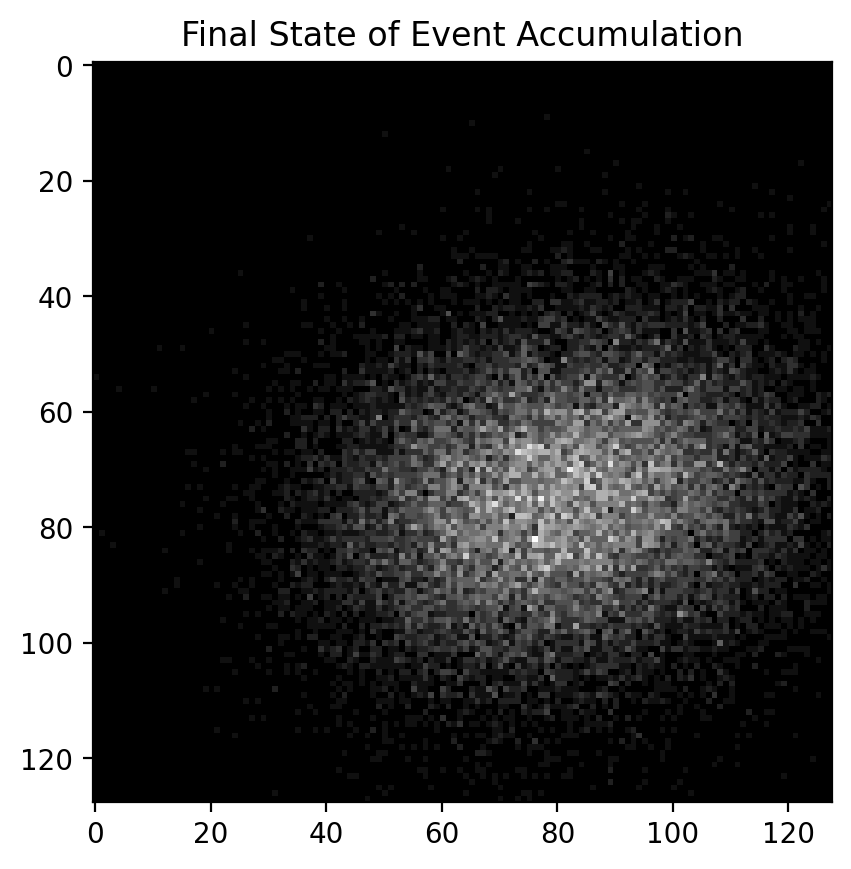

In [9]:
plt.imshow(final_state.permute(1,2,0).numpy(), cmap='gray')
plt.title("Final State of Event Accumulation")
plt.show()

# Building the model

I'll attempt to use a slightly modified but pre-built VideoResnet transformer to model this. 

In [42]:
from torchvision.models.video.resnet import Bottleneck, BasicBlock, Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D
from typing import Any, Callable, List, Optional, Sequence, Tuple, Type, Union
from torch import Tensor

class R2Plus1dStem(nn.Sequential):
    """R(2+1)D stem is different than the default one as it uses separated 3D convolution"""

    def __init__(self) -> None:
        super().__init__(
            nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),
            nn.Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

class VideoResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_makers: Sequence[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]],
        layers: List[int],
        stem: Callable[..., nn.Module],
        # num_classes: int = 400, # We aren't classifying here.
        zero_init_residual: bool = False,
        verbose: bool = False,
    ) -> None:
        """Generic resnet video generator.

        Args:
            block (Type[Union[BasicBlock, Bottleneck]]): resnet building block
            conv_makers (List[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]]): generator
                function for each layer
            layers (List[int]): number of blocks per layer
            stem (Callable[..., nn.Module]): module specifying the ResNet stem.
            ~~num_classes (int, optional): Dimension of the final FC layer. Defaults to 400.~~
            zero_init_residual (bool, optional): Zero init bottleneck residual BN. Defaults to False.
        """
        super().__init__()
        # _log_api_usage_once(self)

        self.verbose = verbose

        self.inplanes = 64

        self.stem = stem()

        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, conv_makers[1], 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, conv_makers[2], 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, conv_makers[3], 512, layers[3], stride=2)
        # Back up to original
        self.layer5 = nn.ConvTranspose3d(512, 256, kernel_size=(2,2,2), stride=(2,2,2))
        self.layer6 = nn.ConvTranspose3d(256, 128, kernel_size=(1,2,2), stride=(2,2,2))
        self.layer7 = nn.ConvTranspose3d(128,  64, kernel_size=(2,2,2), stride=(2,2,2))
        self.layer8 = nn.ConvTranspose3d(64,    1, kernel_size=(1,2,2), stride=(1,2,2))
        self.Softplus = nn.Softplus(beta=10)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 128, 128))
        # self.fc = nn.Linear(512 * block.expansion, num_classes) # Not classifying

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[union-attr, arg-type]

    def print_verbose(self, x):
        if self.verbose:
            print(x)

    def forward(self, x: Tensor) -> Tensor:
        self.print_verbose("Starting")
        x = self.stem(x)
        self.print_verbose(x.shape)
        x = self.layer1(x)
        self.print_verbose(x.shape)
        x = self.layer2(x)
        self.print_verbose(x.shape)
        x = self.layer3(x)
        self.print_verbose(x.shape)
        x = self.layer4(x)
        self.print_verbose(x.shape)
        x = self.layer5(x)
        self.print_verbose(x.shape)
        x = self.layer6(x)
        self.print_verbose(x.shape)
        x = self.layer7(x)
        self.print_verbose(x.shape)
        x = self.layer8(x)
        self.print_verbose(x.shape)
        x = self.avgpool(x)
        self.print_verbose(x.shape)
        x = torch.squeeze(x, 2)
        self.print_verbose(x.shape)
        # Make sure the output is in the range 0,Inf
        x = self.Softplus(x)
        # Flatten the layer to fc # Skip not classifying
        # x = x.flatten(1)
        # x = self.fc(x)
        return x

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_builder: Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=ds_stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)




In [43]:
net = VideoResNet(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem, verbose=True)

In [44]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

32541604

In [45]:
blob, blob_tensor, claims, claims_tensor, final_state = next(iter(train_dataloader))
print(blob_tensor.shape)
print(final_state.shape)

torch.Size([4, 1, 30, 128, 128])
torch.Size([4, 1, 128, 128])


In [46]:
def test():
    # Test dimensions over the architecture
    img = net(blob_tensor)
    print(img.detach().min())
    print(img.detach().max())
test()

gc.collect()
torch.cuda.empty_cache()

Starting
torch.Size([4, 64, 30, 64, 64])


torch.Size([4, 64, 30, 64, 64])
torch.Size([4, 128, 15, 32, 32])
torch.Size([4, 256, 8, 16, 16])
torch.Size([4, 512, 4, 8, 8])
torch.Size([4, 256, 8, 16, 16])
torch.Size([4, 128, 15, 32, 32])
torch.Size([4, 64, 30, 64, 64])
torch.Size([4, 1, 30, 128, 128])
torch.Size([4, 1, 1, 128, 128])
torch.Size([4, 1, 128, 128])
tensor(0.0019)
tensor(0.0746)


## Fitting the model

In [47]:
net = VideoResNet(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem).to("cuda")
if not os.path.isdir('modelsave'):
    os.mkdir('modelsave')

if not 'videoresnet1.pt' in os.listdir('modelsave'):
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    train_loss = []
    epoch_loss = []
    for epoch in tqdm(range(20)):
        for i, data in enumerate(train_dataloader):
            blob, blob_tensor, claims, claims_tensor, final_state  = data
            blob_tensor = blob_tensor.to("cuda")
            final_state = final_state.to("cuda")
            optimizer.zero_grad()
            output_tensor = net(blob_tensor)
            loss_tensor = nn.MSELoss()(
                output_tensor, final_state
            )
            loss_tensor.backward()
            train_loss.append(loss_tensor.cpu().detach().numpy().tolist())
            optimizer.step()
        epoch_loss_one = np.mean(train_loss)
        epoch_loss.append(epoch_loss_one)

    torch.save(net.state_dict(), 'modelsave/videoresnet1.pt')
    with open('modelsave/epoch-loss-1.pkl', 'wb') as fp:
        pickle.dump(epoch_loss, fp)
    with open('modelsave/train-loss-1.pkl', 'wb') as fp:
        pickle.dump(train_loss, fp)
else:
    net.load_state_dict(torch.load('modelsave/videoresnet1.pt'))
    net.eval()
    with open ('modelsave/epoch-loss-1.pkl', 'rb') as fp:
        epoch_loss = pickle.load(fp)
    with open ('modelsave/train-loss-1.pkl', 'rb') as fp:
        train_loss = pickle.load(fp)


## Training loss

Text(0, 0.5, 'Loss (MSE)')

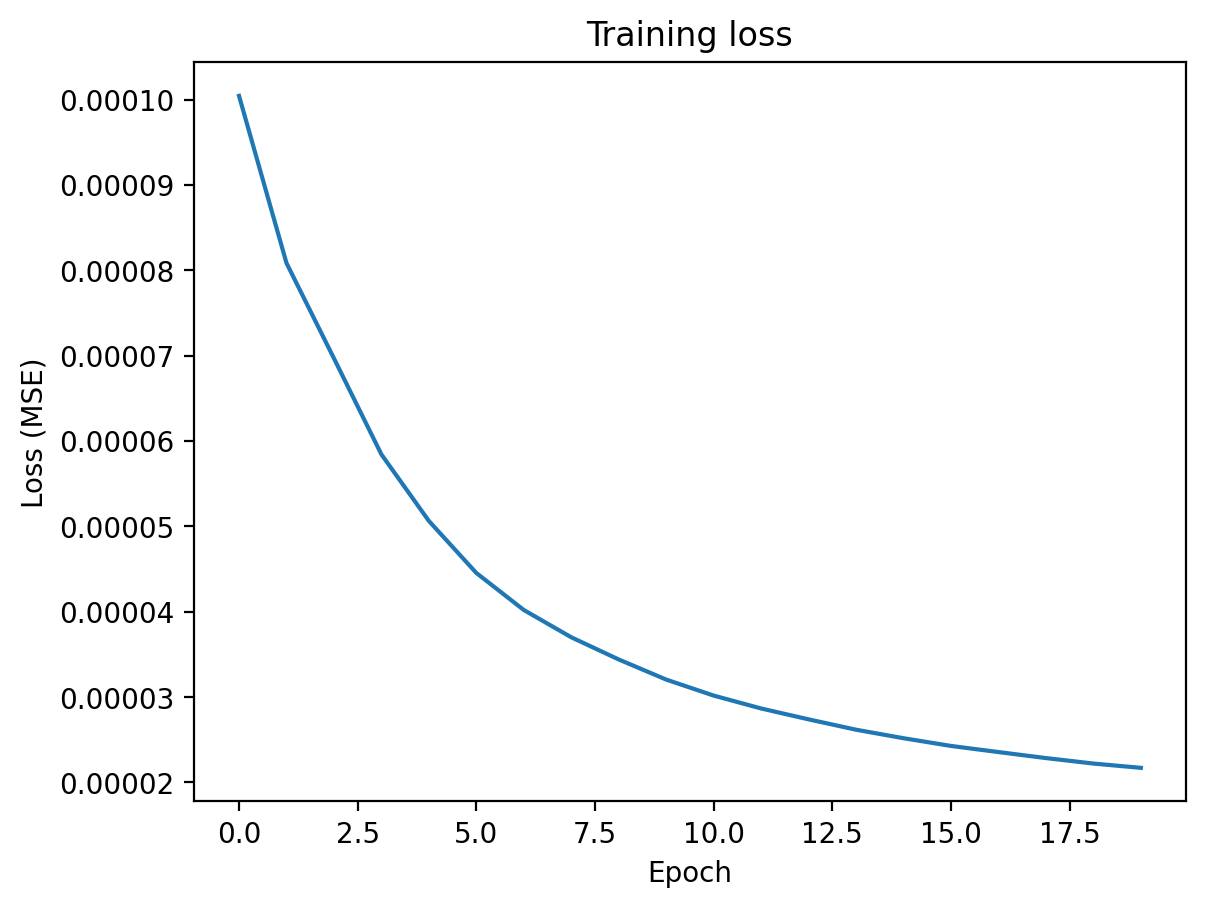

In [48]:
plt.plot(epoch_loss)
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

## Views of prediction on test data

In [49]:
def test():
    # net.eval()
    testdata = CustomVideoDataset(
        file_df.query("train == 0"), VIDEO_DIR, transform_img
    )
    test_dataloader  = DataLoader(testdata,  batch_size=12, shuffle=True)

    blob, blob_tensor, claims, claims_tensor, final_state  = next(iter(test_dataloader))

    blob_tensor = blob_tensor.to("cuda")
    final_state = final_state.to("cuda")
    output_tensor = net(blob_tensor)
    output_tensor = output_tensor.cpu().detach()

    print(output_tensor.shape)
    print(output_tensor.max())
    return final_state, output_tensor

final_state, output_tensor = test()
gc.collect()
torch.cuda.empty_cache()

torch.Size([12, 1, 128, 128])
tensor(0.0682)


Below we observe the output surfaces predicted by the neural network. It does a
mediocre job of predicting the ultimate state, but the output is extremely noisy
and inconsistent.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


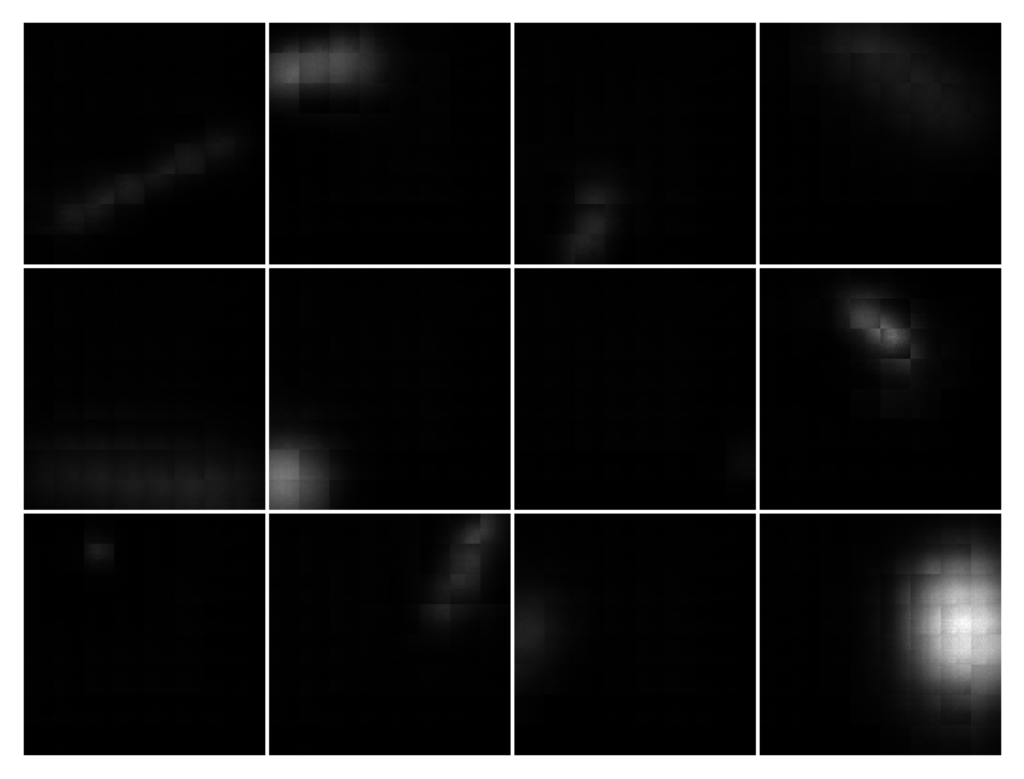

In [50]:
plt.imshow(
    torchvision.utils.make_grid(output_tensor, nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

Compare the above with the true final state for each "blob".

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


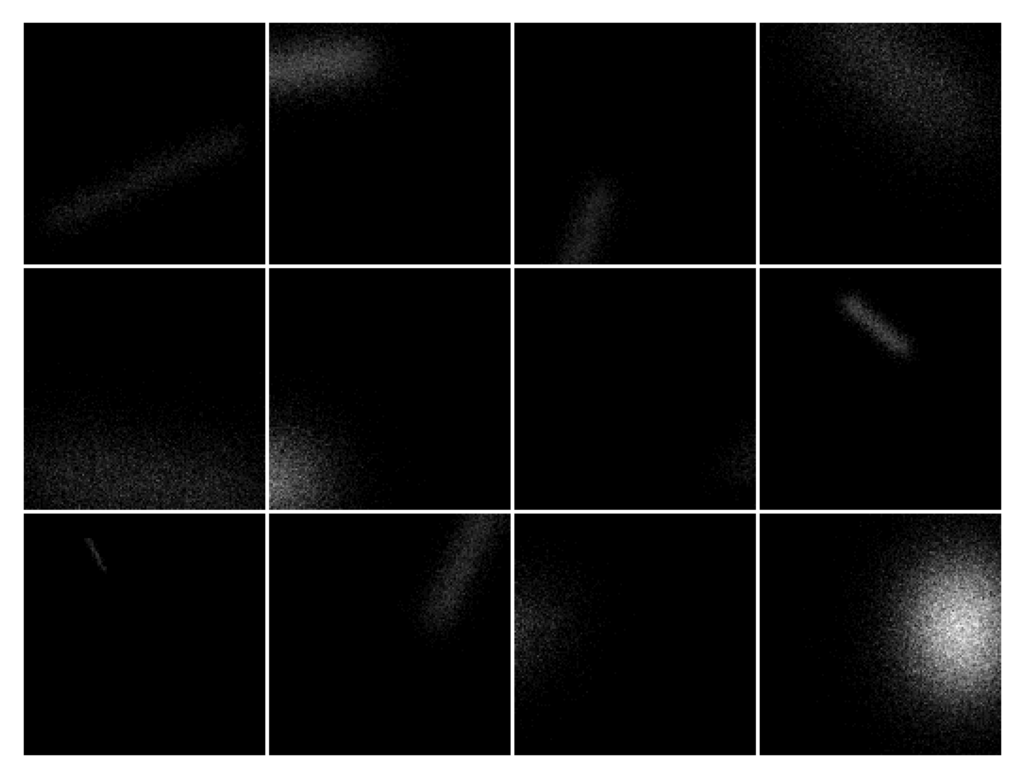

In [51]:
plt.imshow(
    torchvision.utils.make_grid(final_state.cpu(), nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

In [52]:
print((final_state * 255).sum())
print((output_tensor * 255).sum())

tensor(92575., device='cuda:0')
tensor(90847.9219)


# Attempt \#2

A major deficiency of the above model is the use of ConvTranspose3d to scale up
the layers back to the original channels & resolution. I will try using some
sort of skip-connections like U-Net and alternative methods to upsample the
layers.

In [7]:
class R2Plus1dStem(nn.Sequential):
    """R(2+1)D stem is different than the default one as it uses separated 3D convolution"""

    def __init__(self) -> None:
        super().__init__(
            nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),
            nn.Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

class VideoResNet2(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_makers: Sequence[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]],
        layers: List[int],
        stem: Callable[..., nn.Module],
        zero_init_residual: bool = False,
        verbose: bool = False,
    ) -> None:
        """Generic resnet video generator.

        Args:
            block (Type[Union[BasicBlock, Bottleneck]]): resnet building block
            conv_makers (List[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]]): generator
                function for each layer
            layers (List[int]): number of blocks per layer
            stem (Callable[..., nn.Module]): module specifying the ResNet stem.
            ~~num_classes (int, optional): Dimension of the final FC layer. Defaults to 400.~~
            zero_init_residual (bool, optional): Zero init bottleneck residual BN. Defaults to False.
        """
        super().__init__()

        self.verbose = verbose

        self.inplanes = 64
        self.stem = stem()
        # Downsamples with the temporal
        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, conv_makers[1], 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, conv_makers[2], 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, conv_makers[3], 512, layers[3], stride=2)
        # Back up to original
        self.layer5 = self.double_conv(512+256, 256)
        self.layer6 = self.double_conv(256+128, 128)
        self.layer7 = self.double_conv(128+64, 64)
        self.layer8 = self.double_conv(64+1, 1)
        self.final = nn.Softplus(10)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 128, 128))

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[union-attr, arg-type]

    def print_verbose(self, x):
        if self.verbose:
            print(x)

    def forward(self, x: Tensor) -> Tensor:
        self.print_verbose("Starting")
        # Downsampling
        self.print_verbose("Layer input " + str(x.shape))
        conv0 = x
        x = self.stem(x)
        self.print_verbose("Layer 0 " + str(x.shape))
        conv1 = x = self.layer1(x)
        self.print_verbose("Layer 1 " + str(x.shape))
        conv2 = x = self.layer2(x)
        self.print_verbose("Layer 2 " + str(x.shape))
        conv3 = x = self.layer3(x)
        self.print_verbose("Layer 3 " + str(x.shape))
        x = self.layer4(x)
        self.print_verbose("Layer 4 " + str(x.shape))

        # Upsample ---------------------------------
        x = nn.Upsample([8, 16, 16], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 5 " + str(x.shape))
        x = torch.cat([x, conv3], dim=1)
        self.print_verbose("Layer 5 " + str(x.shape))
        x = self.layer5(x)
        self.print_verbose("Layer 5 " + str(x.shape))
        # Upsample ---------------------------------
        x = nn.Upsample([15, 32, 32], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 6 " + str(x.shape))
        x = torch.cat([x, conv2], dim=1)
        self.print_verbose("Layer 6 " + str(x.shape))
        x = self.layer6(x)
        self.print_verbose("Layer 6 " + str(x.shape))
        # Upsample ---------------------------------
        x = nn.Upsample([30, 64, 64], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 7 " + str(x.shape))
        x = torch.cat([x, conv1], dim=1)
        self.print_verbose("Layer 7 " + str(x.shape))
        x = self.layer7(x)
        self.print_verbose("Layer 7 " + str(x.shape))
        # Upsample ---------------------------------
        x = nn.Upsample([30, 128, 128], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 8 " + str(x.shape))
        x = torch.cat([x, conv0], dim=1)
        self.print_verbose("Layer 8 " + str(x.shape))
        x = self.layer8(x)
        self.print_verbose("Layer 8 " + str(x.shape))
        # Average pool & squeeze to output dimensions
        x = self.avgpool(x)
        self.print_verbose("After avgpool " + str(x.shape))
        x = torch.squeeze(x, 2)
        self.print_verbose("After squeeze " + str(x.shape))
        # Make sure the output is in the range 0,Inf
        x = self.final(x)
        return x

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_builder: Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=ds_stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )


In [8]:
net = VideoResNet2(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem, verbose=True)

In [9]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

40588123

In [59]:
blob, blob_tensor, claims, claims_tensor, final_state = next(iter(train_dataloader))
print(blob_tensor.shape)
print(final_state.shape)

torch.Size([4, 1, 30, 128, 128])
torch.Size([4, 1, 128, 128])


In [60]:
output_tensor = net(blob_tensor)
output_tensor = output_tensor.cpu().detach()

print(output_tensor.max())

Starting
Layer input torch.Size([4, 1, 30, 128, 128])
Layer 0 torch.Size([4, 64, 30, 64, 64])


Layer 1 torch.Size([4, 64, 30, 64, 64])
Layer 2 torch.Size([4, 128, 15, 32, 32])
Layer 3 torch.Size([4, 256, 8, 16, 16])
Layer 4 torch.Size([4, 512, 4, 8, 8])
Layer 5 torch.Size([4, 512, 8, 16, 16])
Layer 5 torch.Size([4, 768, 8, 16, 16])
Layer 5 torch.Size([4, 256, 8, 16, 16])
Layer 6 torch.Size([4, 256, 15, 32, 32])
Layer 6 torch.Size([4, 384, 15, 32, 32])
Layer 6 torch.Size([4, 128, 15, 32, 32])
Layer 7 torch.Size([4, 128, 30, 64, 64])
Layer 7 torch.Size([4, 192, 30, 64, 64])
Layer 7 torch.Size([4, 64, 30, 64, 64])
Layer 8 torch.Size([4, 64, 30, 128, 128])
Layer 8 torch.Size([4, 65, 30, 128, 128])
Layer 8 torch.Size([4, 1, 30, 128, 128])
After avgpool torch.Size([4, 1, 1, 128, 128])
After squeeze torch.Size([4, 1, 128, 128])
tensor(15.2291)


In [61]:
del output_tensor, net, blob, blob_tensor, claims, claims_tensor, final_state
gc.collect()
torch.cuda.empty_cache()

In [10]:
traindata = CustomVideoDataset(
    file_df.query("train == 1 & video_no < 100"), VIDEO_DIR, transform_img
)

In [11]:
train_dataloader = DataLoader(traindata, batch_size=4, shuffle=True)

net = VideoResNet2(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem).to("cuda")
if not os.path.isdir('modelsave'):
    os.mkdir('modelsave')

if not 'videoresnet2.pt' in os.listdir('modelsave'):
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    outputs = []
    train_loss = []
    epoch_loss = []
    for epoch in tqdm(range(10)):
        for i, data in enumerate(train_dataloader):
            blob, blob_tensor, claims, claims_tensor, final_state = data
            blob_tensor = blob_tensor.to("cuda")
            final_state = final_state.to("cuda")
            optimizer.zero_grad()
            output_tensor = net(blob_tensor)
            outputs.append(output_tensor.cpu().detach())
            loss_tensor = nn.MSELoss()(
                output_tensor, final_state
            )
            loss_tensor.backward()
            train_loss.append(loss_tensor.cpu().detach().numpy().tolist())
            optimizer.step()
        epoch_loss_one = np.mean(train_loss)
        epoch_loss.append(epoch_loss_one)

    torch.save(net.state_dict(), 'modelsave/videoresnet2.pt')
    with open('modelsave/epoch-loss-2.pkl', 'wb') as fp:
        pickle.dump(epoch_loss, fp)
    with open('modelsave/train-loss-2.pkl', 'wb') as fp:
        pickle.dump(train_loss, fp)
else:
    net.load_state_dict(torch.load('modelsave/videoresnet2.pt'))
    with open ('modelsave/epoch-loss-2.pkl', 'rb') as fp:
        epoch_loss = pickle.load(fp)
    with open ('modelsave/train-loss-2.pkl', 'rb') as fp:
        train_loss = pickle.load(fp)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss (MSE)')

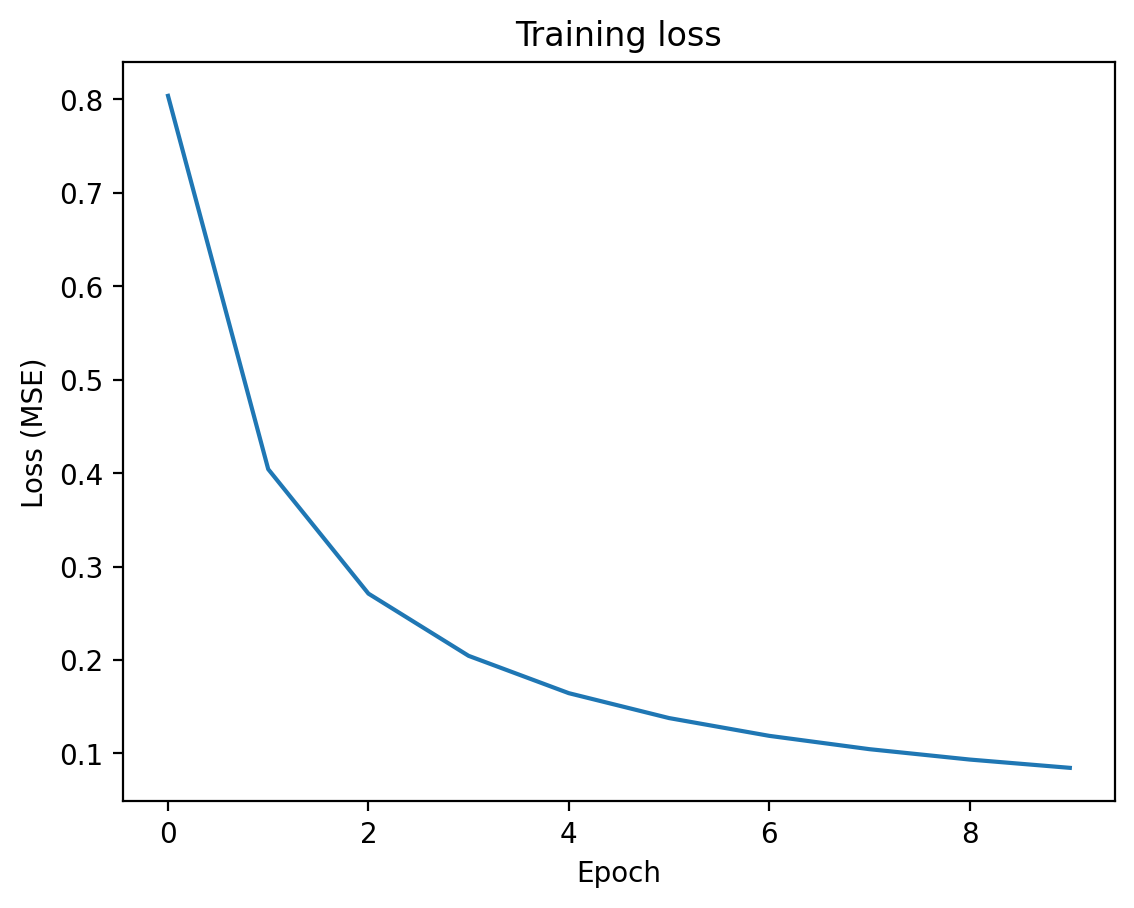

In [12]:
plt.plot(epoch_loss)
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

In [13]:
gc.collect()
torch.cuda.empty_cache()

In [15]:
net.eval()

testdata = CustomVideoDataset(
    file_df.query("train == 0"), VIDEO_DIR, transform_img
)

blob, blob_tensor, claims, claims_tensor, final_state  = testdata.__getitem__(2)

def predict(net, blob_tensor):
    blob_tensor = blob_tensor.to("cuda")
    output_tensor = net(blob_tensor)
    output_tensor = output_tensor.cpu().detach()
    return output_tensor

output_tensor = predict(net, torch.unsqueeze(blob_tensor,0))

gc.collect()
torch.cuda.empty_cache()

In [16]:
print(output_tensor.shape)
print(output_tensor.max())
print(final_state.shape)

torch.Size([1, 1, 128, 128])
tensor(0.0693)
torch.Size([1, 128, 128])


In [43]:
del blob, blob_tensor, claims, claims_tensor, net
gc.collect()
torch.cuda.empty_cache()

# Whoops

The resulting output is uniform, and the sum of the values is very large in magnitude relative to the true final state.

There is something that is completely destroying any variance in the output.

In [18]:
def test(net):
    net.eval()
    testdata = CustomVideoDataset(
        file_df.query("train == 0"), VIDEO_DIR, transform_img
    )
    test_dataloader  = DataLoader(testdata,  batch_size=12, shuffle=True)

    blob, blob_tensor, claims, claims_tensor, final_state  = next(iter(test_dataloader))

    blob_tensor = blob_tensor.to("cuda")
    final_state = final_state.to("cuda")
    output_tensor = net(blob_tensor)
    output_tensor = output_tensor.cpu().detach()

    print(output_tensor.shape)
    print(output_tensor.max())
    return final_state, output_tensor

final_state, output_tensor = test(net)

torch.Size([12, 1, 128, 128])
tensor(0.0693)


There's 0 variance here:

In [27]:
torch.var(output_tensor)

tensor(0.)

In [19]:
gc.collect()
torch.cuda.empty_cache()

The plot is a blank slate of one repeated value

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


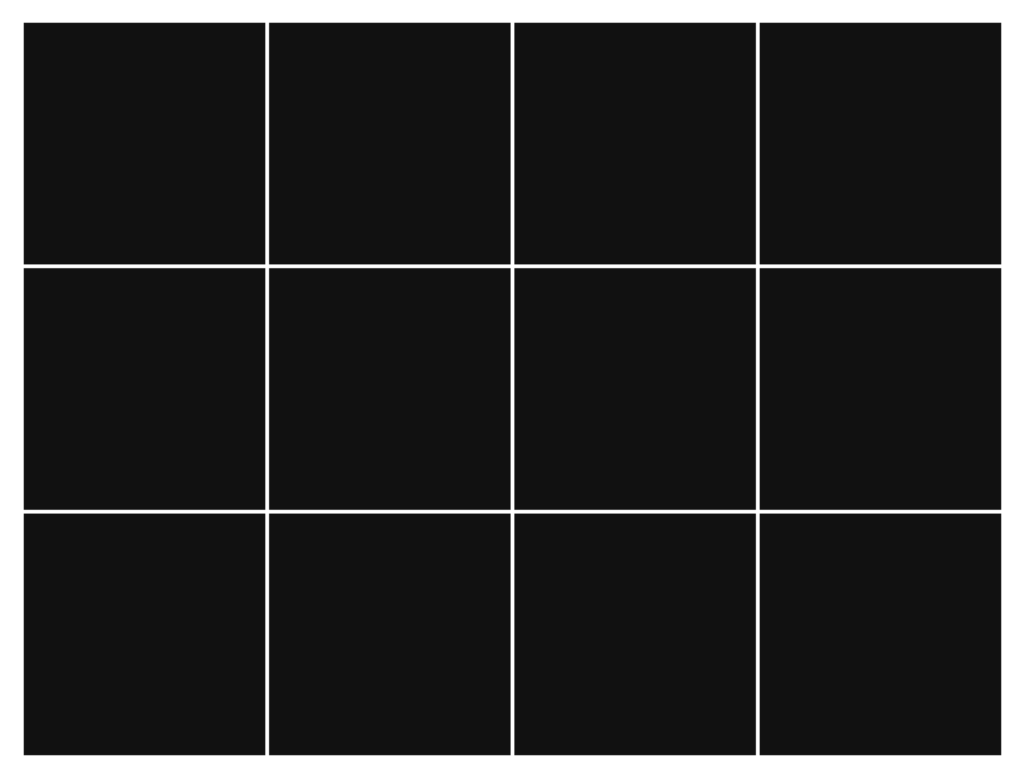

In [20]:
plt.imshow(
    torchvision.utils.make_grid(output_tensor, nrow=4, normalize=False, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


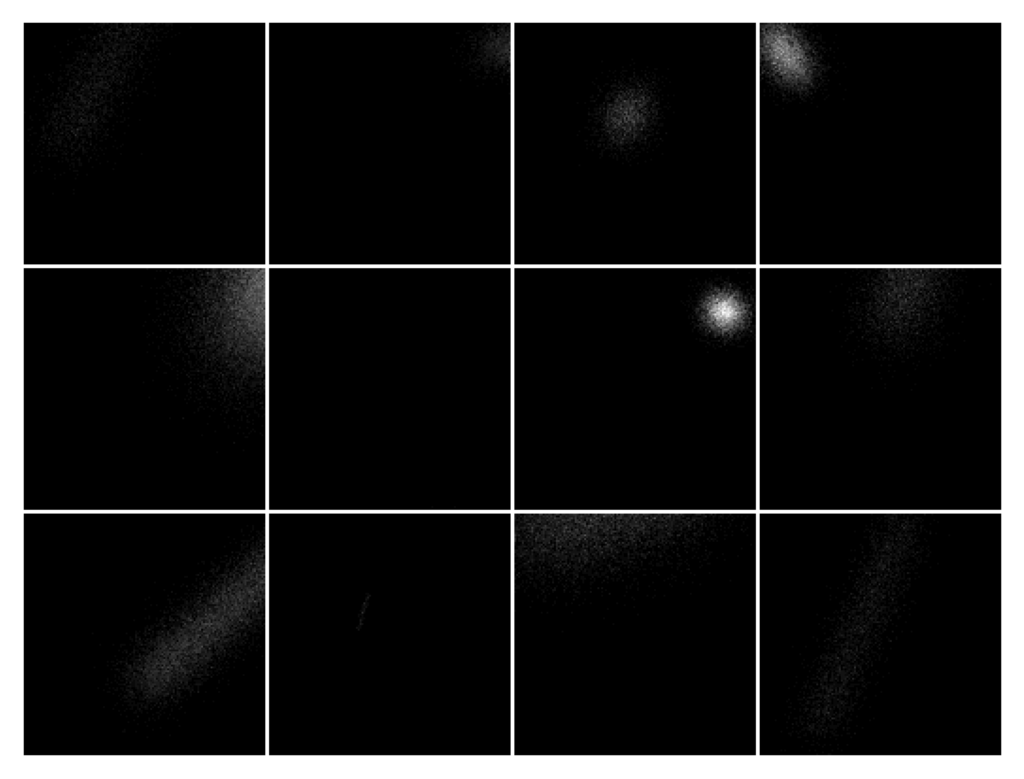

In [21]:
plt.imshow(
    torchvision.utils.make_grid(final_state.cpu(), nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

In [22]:
print((final_state * 255).sum())
print((output_tensor * 255).sum())

tensor(47549., device='cuda:0')
tensor(3475095.2500)


In [23]:
print((final_state * 255).mean())
(output_tensor*255).mean()

tensor(0.2418, device='cuda:0')


tensor(17.6752)

## Decomposing malformed output

We can rewrite the model class to output more intermediate products at prediction time

In [14]:
class R2Plus1dStem(nn.Sequential):
    """R(2+1)D stem is different than the default one as it uses separated 3D convolution"""

    def __init__(self) -> None:
        super().__init__(
            nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),
            nn.Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

class VideoResNet2(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_makers: Sequence[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]],
        layers: List[int],
        stem: Callable[..., nn.Module],
        zero_init_residual: bool = False,
        verbose: bool = False,
    ) -> None:
        """Generic resnet video generator.

        Args:
            block (Type[Union[BasicBlock, Bottleneck]]): resnet building block
            conv_makers (List[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]]): generator
                function for each layer
            layers (List[int]): number of blocks per layer
            stem (Callable[..., nn.Module]): module specifying the ResNet stem.
            ~~num_classes (int, optional): Dimension of the final FC layer. Defaults to 400.~~
            zero_init_residual (bool, optional): Zero init bottleneck residual BN. Defaults to False.
        """
        super().__init__()

        self.verbose = verbose

        self.inplanes = 64
        self.stem = stem()
        # Downsamples with the temporal
        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, conv_makers[1], 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, conv_makers[2], 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, conv_makers[3], 512, layers[3], stride=2)
        # Back up to original
        self.layer5 = self.double_conv(512+256, 256)
        self.layer6 = self.double_conv(256+128, 128)
        self.layer7 = self.double_conv(128+64, 64)
        self.layer8 = self.double_conv(64+1, 1)
        self.final = nn.Softplus(10)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 128, 128))

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[union-attr, arg-type]

    def print_verbose(self, x):
        if self.verbose:
            print(x)

    def forward(self, x: Tensor) -> Tensor:
        self.print_verbose("Starting")
        # Downsampling
        self.print_verbose("Layer input " + str(x.shape))
        conv0 = x
        x = self.stem(x)
        self.print_verbose("Layer 0 " + str(x.shape))
        conv1 = x = self.layer1(x)
        self.print_verbose("Layer 1 " + str(x.shape))
        conv2 = x = self.layer2(x)
        self.print_verbose("Layer 2 " + str(x.shape))
        conv3 = x = self.layer3(x)
        self.print_verbose("Layer 3 " + str(x.shape))
        x = self.layer4(x)
        self.print_verbose("Layer 4 " + str(x.shape))

        # Upsample ---------------------------------
        first_upsample = x = nn.Upsample([8, 16, 16], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 5 " + str(x.shape))
        first_concat = x = torch.cat([x, conv3], dim=1)
        self.print_verbose("Layer 5 " + str(x.shape))
        first_conv = x = self.layer5(x)
        self.print_verbose("Layer 5 " + str(x.shape))
        # Upsample ---------------------------------
        x = nn.Upsample([15, 32, 32], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 6 " + str(x.shape))
        x = torch.cat([x, conv2], dim=1)
        self.print_verbose("Layer 6 " + str(x.shape))
        x = self.layer6(x)
        self.print_verbose("Layer 6 " + str(x.shape))
        # Upsample ---------------------------------
        x = nn.Upsample([30, 64, 64], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 7 " + str(x.shape))
        x = torch.cat([x, conv1], dim=1)
        self.print_verbose("Layer 7 " + str(x.shape))
        x = self.layer7(x)
        self.print_verbose("Layer 7 " + str(x.shape))
        # Upsample ---------------------------------
        x = nn.Upsample([30, 128, 128], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 8 " + str(x.shape))
        x = torch.cat([x, conv0], dim=1)
        self.print_verbose("Layer 8 " + str(x.shape))
        predicted_video = x = self.layer8(x)
        self.print_verbose("Layer 8 " + str(x.shape))
        # Average pool & squeeze to output dimensions
        x = self.avgpool(x)
        self.print_verbose("After avgpool " + str(x.shape))
        after_avg_pool = x = torch.squeeze(x, 2)
        self.print_verbose("After squeeze " + str(x.shape))
        # Make sure the output is in the range 0,Inf
        x = self.final(x)
        return x, first_upsample, first_concat, first_conv, predicted_video, after_avg_pool

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_builder: Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=ds_stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

net = VideoResNet2(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem, verbose=True)
# Load the weights fit from the previous model run. The only difference is that now we are output
net.load_state_dict(torch.load('modelsave/videoresnet2.pt'))
net = net.eval()

Now when we produce a prediction, we can see what the intermediate values look like. Let's pull out a single dataset from our training set.

In [16]:
# Extract a single training example
blob, blob_tensor, claims, claims_tensor, final_state = traindata.__getitem__(2)
blob_tensor = torch.unsqueeze(blob_tensor, 0)
blob_tensor.shape

torch.Size([1, 1, 30, 128, 128])

In [17]:
prediction, first_upsample, first_concat, first_conv, predicted_video, after_avg_pool = net(blob_tensor)

Starting
Layer input torch.Size([1, 1, 30, 128, 128])
Layer 0 torch.Size([1, 64, 30, 64, 64])
Layer 1 torch.Size([1, 64, 30, 64, 64])
Layer 2 torch.Size([1, 128, 15, 32, 32])
Layer 3 torch.Size([1, 256, 8, 16, 16])
Layer 4 torch.Size([1, 512, 4, 8, 8])
Layer 5 torch.Size([1, 512, 8, 16, 16])
Layer 5 torch.Size([1, 768, 8, 16, 16])
Layer 5 torch.Size([1, 256, 8, 16, 16])
Layer 6 torch.Size([1, 256, 15, 32, 32])
Layer 6 torch.Size([1, 384, 15, 32, 32])
Layer 6 torch.Size([1, 128, 15, 32, 32])
Layer 7 torch.Size([1, 128, 30, 64, 64])
Layer 7 torch.Size([1, 192, 30, 64, 64])
Layer 7 torch.Size([1, 64, 30, 64, 64])
Layer 8 torch.Size([1, 64, 30, 128, 128])
Layer 8 torch.Size([1, 65, 30, 128, 128])
Layer 8 torch.Size([1, 1, 30, 128, 128])
After avgpool torch.Size([1, 1, 1, 128, 128])
After squeeze torch.Size([1, 1, 128, 128])


Once again, the blob movement looks like the following:

<img src="output_images/blob.gif" width="750" align="center">

This is what the final state looks like:

tensor(0.0050)
tensor(0.0627)
tensor(8.2824e-05)


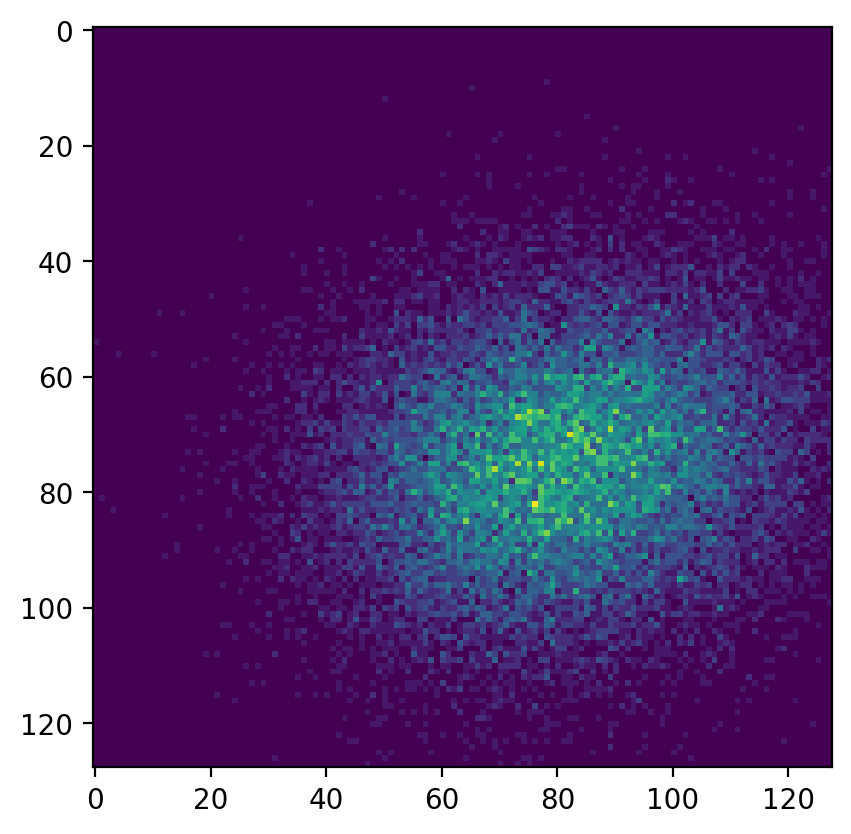

In [93]:
plt.imshow(final_state.permute(1,2,0))
print(final_state.mean())
print(final_state.max())
print(final_state.var())

In [92]:
print(first_upsample.shape)
print(first_upsample.mean())
print(first_upsample.max())

torch.Size([1, 512, 8, 16, 16])
tensor(0.3635, grad_fn=<MeanBackward0>)
tensor(5.2731, grad_fn=<MaxBackward1>)
tensor(0.1576, grad_fn=<VarBackward0>)


There are 8 levels of depth, so we can draw them on the x axis, and put the rest
of the channels on the y-axis. We can see how each channel depicts some
representation of the system evolving over time. Along the 8 layers of depth, it 
seems time is preserved.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.09997227


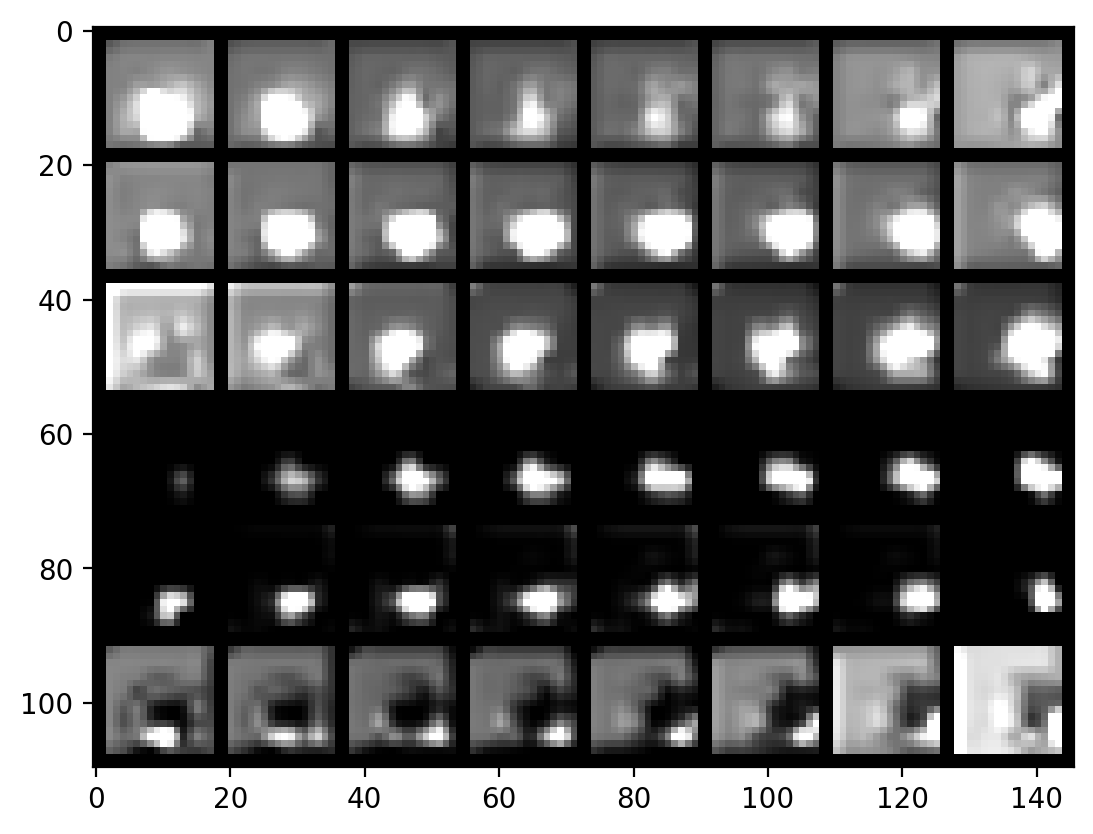

In [97]:
img = torch.flatten(first_upsample, 0, 2)
img = torch.unsqueeze(img,1)
img = [x for x in img][-48:]
variances = [x.var().detach().numpy() for x in img]
print(np.mean(variances))
plt.imshow(
    torchvision.utils.make_grid(img, nrow = 8).permute(1,2,0)
)

The first concatenation adds 256 channels to the `first_upsample`. The final 
`256*8=2048` elements should be from the last convolution before upsampling.

In [102]:
print(first_concat.shape)
print(first_concat.mean())
print(first_concat.max())
print(first_concat.var())

torch.Size([1, 768, 8, 16, 16])
tensor(0.3726, grad_fn=<MeanBackward0>)
tensor(14.8716, grad_fn=<MaxBackward1>)
tensor(0.2490, grad_fn=<VarBackward0>)


At this point, slicing 96 elements around the 512th index, we can see
(presumably) where the concatenation takes place, and where the pattern shifts
to that of the upsampled data to the concatenated convolved data. The difference
is not stark.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([6144, 1, 16, 16])
0.060580134


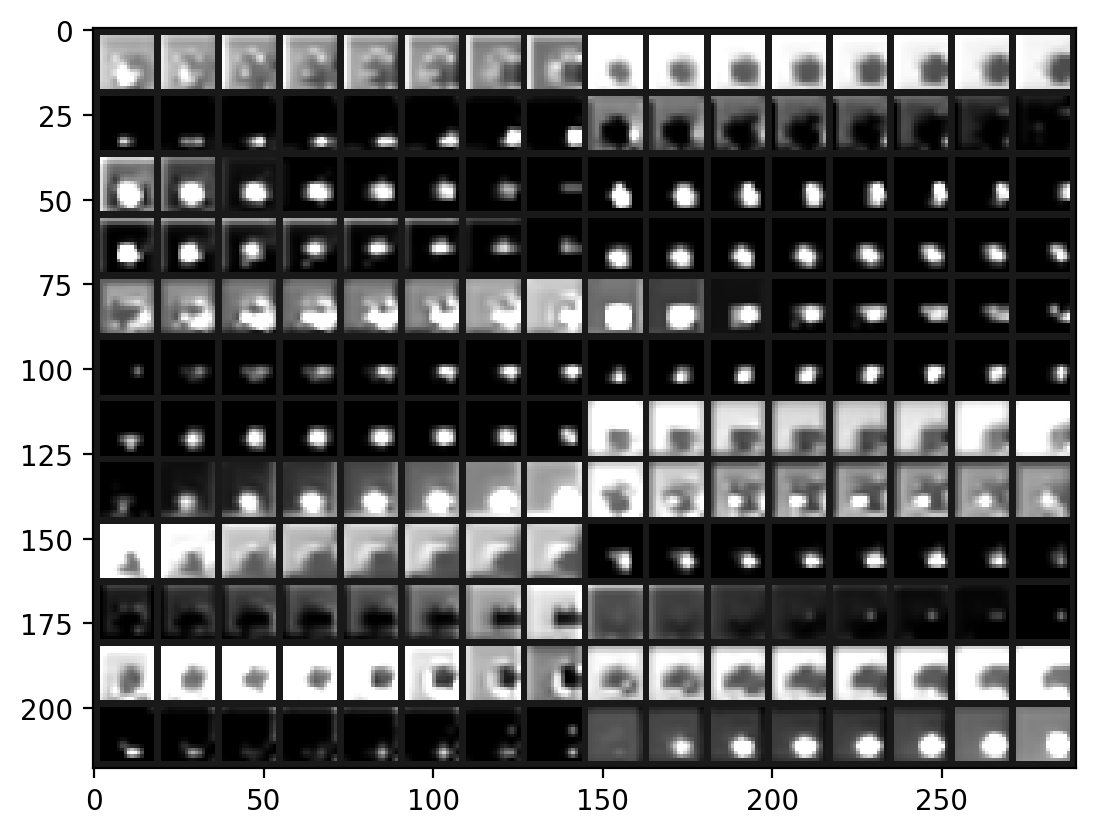

In [98]:
img = torch.flatten(first_concat, 0, 2)
img = torch.unsqueeze(img,1)
print(img.shape)
index = 512
img = [x for x in img][(index-(8*12)):(index+(8*12))]
variances = [x.var().detach().numpy() for x in img]
print(np.mean(variances))
plt.imshow(
    torchvision.utils.make_grid(img, nrow = 8*2, pad_value=0.1).permute(1,2,0)
)

Now we look at the results of the convolution after having concatenated the values. Here is where things go awry. It appears that the variance in most of these layers drops to 0, and most layers are producing either a very high value or 0.

In [103]:
print(first_conv.shape)
print(first_conv.mean())
print(first_conv.max())
print(first_conv.var())

torch.Size([1, 256, 8, 16, 16])
tensor(125.8320, grad_fn=<MeanBackward0>)
tensor(1507.0328, grad_fn=<MaxBackward1>)
tensor(41229.8594, grad_fn=<VarBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2048, 1, 16, 16])


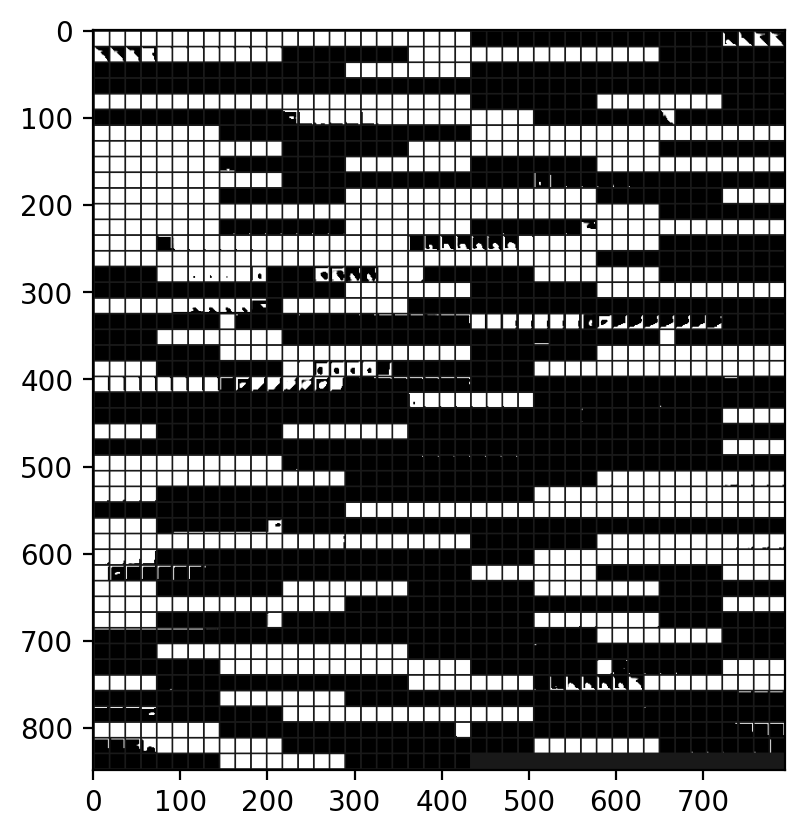

In [100]:
img = torch.flatten(first_conv, 0, 2)
img = torch.unsqueeze(img,1)
print(img.shape)
img = [x for x in img]
variances = [x.var().detach().numpy() for x in img]
plt.imshow(
    torchvision.utils.make_grid(img, nrow = 44, pad_value=0.1).permute(1,2,0)
)

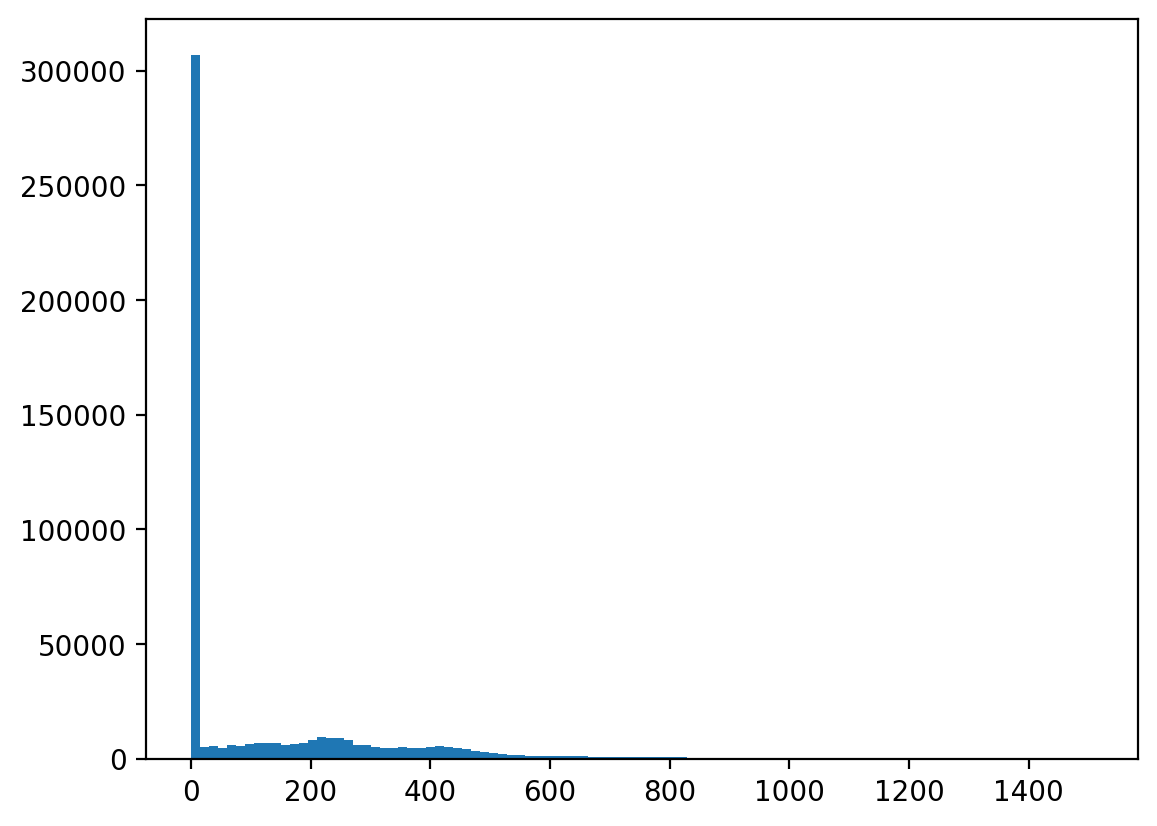

In [111]:
plt.hist(first_conv.flatten().detach().numpy(), bins=100)
plt.show()

# Attempt 3 

I'll attempt to distill and simplify the network, producing and capturing output at intermediate steps to better observe any issues.

In [74]:
# Most of this is repeated from above.
VIDEO_DIR = 'simvid'

def sort_folders(folders, split_idx):
    idx = [int(x.split("_")[split_idx]) for x in folders]
    folders = [x for _, x in sorted(zip(idx, folders))]
    idx.sort()
    return folders, idx

video_dirs, video_idx = sort_folders(os.listdir(VIDEO_DIR), 1)

random.seed(123)

file_df = pd.DataFrame({
    "video_no": video_idx,
    "video_dirs": video_dirs,
    "train": random.choices([0, 1], weights = [0.2, 0.8], k=len(video_dirs))
})

# Recreate data loader to output video ID, so we can track a data item's predictions as the network trains.
class CustomVideoDataset(Dataset):
    def __init__(self, df, parent_dir, transform_img):
        self.parent_dir = parent_dir
        self.videos = df.video_dirs.tolist()
        self.video_numbers = df.video_no.tolist()
        self.transform_img = transform_img
    def sort_files(self, files, split_idx):
        """
        Sort files based on the third element in the image file name within the video directory.
        Videos are named like so [blob|claim]_frame_##.png. Sorting is done on the third element, or index 2.
        """
        files = [os.path.splitext(x)[0] for x in files]
        idx = [int(x.split("_")[split_idx]) for x in files]
        files = [x for _, x in sorted(zip(idx, files))]
        idx.sort()
        return files, idx
    def __len__(self):
        return len(self.videos)
    def __getitem__(self, idx):
        # Get frames from video set
        video_dir = os.path.join(self.parent_dir, self.videos[idx])
        video_id  = self.video_numbers[idx]
        # Get blob files
        blob_frame_files = glob.glob("blob*", root_dir=video_dir)
        blob_frame_files, _ = self.sort_files(blob_frame_files, 2)
        blob_frame_files = [os.path.join(video_dir, x + '.png') for x in blob_frame_files]
        blob_frame_images = [self.transform_img(Image.open(x)) for x in blob_frame_files]
        blob_tensor = torch.stack(blob_frame_images, dim=1)
        # Get claims data files
        claims_data_files = glob.glob("claims_data_*.png", root_dir=video_dir)
        claims_data_files, _ = self.sort_files(claims_data_files, 2)
        claims_data_files = [os.path.join(video_dir, x + '.png') for x in claims_data_files]
        claims_data_images = [self.transform_img(Image.open(x)) for x in claims_data_files]
        claims_final_state = claims_data_images[-1]
        claims_tensor = torch.stack(claims_data_images, dim=1)
        # Get final claims state
        return blob_frame_images, blob_tensor, claims_data_images, claims_tensor, claims_final_state, video_id

The main changes to the model framework here are: 

- Removal of all intermediate layers, so that we just have one encoding and one decoding series.
- Final step is ReLU
- Added batchnorm3d to the resnet portion. This should probably have been done from the outset, the `__init__` is basically a resnet.

In [75]:
# Simplify model structure.

class R2Plus1dStem(nn.Sequential):
    """R(2+1)D stem is different than the default one as it uses separated 3D convolution"""

    def __init__(self) -> None:
        super().__init__(
            nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),
            nn.Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

class VideoResNet3(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_makers: Sequence[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]],
        layers: List[int],
        stem: Callable[..., nn.Module],
        zero_init_residual: bool = False,
        verbose: bool = False,
    ) -> None:
        """Generic resnet video generator.

        Args:
            block (Type[Union[BasicBlock, Bottleneck]]): resnet building block
            conv_makers (List[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]]): generator
                function for each layer
            layers (List[int]): number of blocks per layer
            stem (Callable[..., nn.Module]): module specifying the ResNet stem.
            ~~num_classes (int, optional): Dimension of the final FC layer. Defaults to 400.~~
            zero_init_residual (bool, optional): Zero init bottleneck residual BN. Defaults to False.
        """
        super().__init__()

        self.verbose = verbose

        self.inplanes = 64
        self.stem = stem()
        # Downsamples with the temporal
        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.layer8 = self.double_conv(64+1, 1)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 128, 128))
        self.final = nn.ReLU()

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[union-attr, arg-type]

    def print_verbose(self, x):
        if self.verbose:
            print(x)

    def forward(self, x: Tensor) -> Tensor:
        self.print_verbose("Starting")
        # Encoding -------------------------------------------------------------
        self.print_verbose("Layer input " + str(x.shape))
        conv0 = x
        stem_result = x = self.stem(x)
        self.print_verbose("Layer 0 " + str(x.shape))
        encoding = x = self.layer1(x)
        self.print_verbose("Layer 1 " + str(x.shape))
        # Decoding -------------------------------------------------------------
        upsample = x = nn.Upsample([30, 128, 128], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 8 " + str(x.shape))
        x = torch.cat([x, conv0], dim=1)
        self.print_verbose("Layer 8 " + str(x.shape))
        output_video = x = self.layer8(x)
        self.print_verbose("Layer 8 " + str(x.shape))
        # Final output
        avgpool = x = self.avgpool(x)
        x = torch.squeeze(x, 2)
        self.print_verbose("After squeeze " + str(x.shape))
        # Make sure the output is in the range 0,Inf
        x = self.final(x)
        return x, stem_result, encoding, upsample, output_video, avgpool

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_builder: Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=ds_stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

In [76]:
def model_fit(net, train_dataloader, index, output_dir, epochs):
    model_save = f'videoresnet{index}.pt'
    epoch_loss_save = f'epoch-loss-{index}.pkl'
    outputs_save = f'output-tensors-{index}.pkl'
    items_dir = os.path.join(output_dir, f'outputs-{index}')
    if not os.path.isdir(items_dir):
        os.mkdir(items_dir)
    if not model_save in os.listdir(items_dir):
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        train_loss = []
        epoch_loss = []
        outputs = []
        for epoch in tqdm(range(epochs)):
            for _, data in enumerate(train_dataloader):
                _, blob_tensor, _, _, final_state, video_id = data
                blob_tensor = blob_tensor.to("cuda")
                final_state = final_state.to("cuda")
                optimizer.zero_grad()
                res = net(blob_tensor)
                output_tensor, stem_result, encoding, upsample, output_video, avgpool = res
                loss_tensor = nn.MSELoss()(
                    output_tensor, final_state
                )
                loss_tensor.backward()
                train_loss.append(loss_tensor.cpu().detach().numpy().tolist())
                optimizer.step()
                if (video_id == 6):
                    res = tuple(map(lambda x: x.cpu().detach(), res))
                    outputs.append(res)
            epoch_loss_one = np.mean(train_loss)
            epoch_loss.append(epoch_loss_one)

        torch.save(net.state_dict(), os.path.join(items_dir, model_save))
        with open(os.path.join(items_dir, epoch_loss_save), 'wb') as fp:
            pickle.dump(epoch_loss, fp)
        with open(os.path.join(items_dir, outputs_save), 'wb') as fp:
            pickle.dump(outputs, fp)
    else:
        net.load_state_dict(torch.load(os.path.join(items_dir, model_save)))
        net.eval()
        with open (os.path.join(items_dir, epoch_loss_save), 'rb') as fp:
            epoch_loss = pickle.load(fp)
        with open (os.path.join(items_dir, outputs_save), 'rb') as fp:
            outputs = pickle.load(fp)
    return net, epoch_loss, outputs

In [77]:
transform_img = transforms.Compose(
    [
        transforms.Grayscale(1),
        transforms.ToTensor()
    ]
)
traindata = CustomVideoDataset(
    file_df.query("train == 1"), VIDEO_DIR, transform_img
)
train_dataloader = DataLoader(traindata, batch_size = 1, shuffle = True)

In [78]:
net = VideoResNet3(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem, verbose=True)
blob, blob_tensor, _, _, _, _ = traindata.__getitem__(2)
tmp = net(torch.unsqueeze(blob_tensor, 0))

Starting
Layer input torch.Size([1, 1, 30, 128, 128])
Layer 0 torch.Size([1, 64, 30, 64, 64])
Layer 1 torch.Size([1, 64, 30, 64, 64])
Layer 8 torch.Size([1, 64, 30, 128, 128])
Layer 8 torch.Size([1, 65, 30, 128, 128])
Layer 8 torch.Size([1, 1, 30, 128, 128])
After squeeze torch.Size([1, 1, 128, 128])


In [79]:
net = VideoResNet3(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem, verbose=False)
net = net.to('cuda')
net, epoch_loss, outputs = model_fit(net, train_dataloader, 3, 'modelsave', 20)

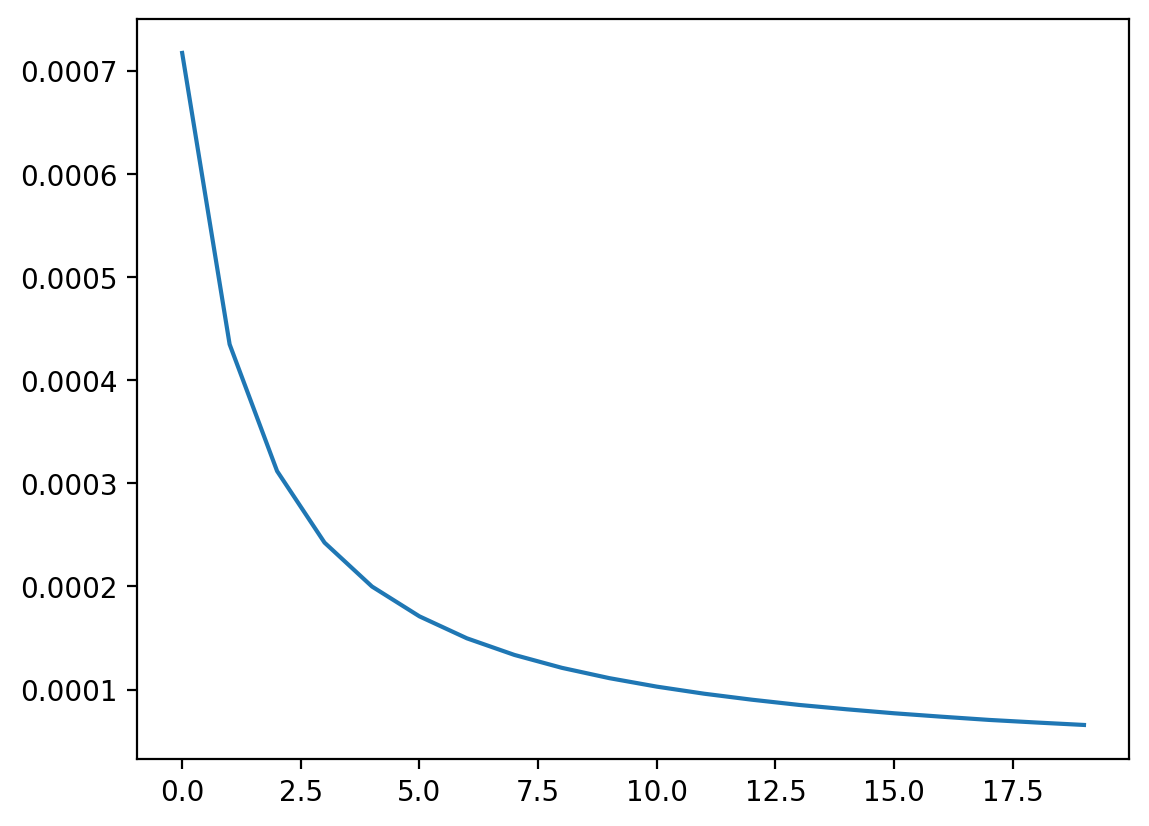

In [80]:
plt.plot(epoch_loss)

In [81]:
output_states = [torch.squeeze(x[0], 0) for x in outputs]
[x.shape for x in output_states]

[torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128])]

Text(0.5, 1.0, 'Final prediction by epoch')

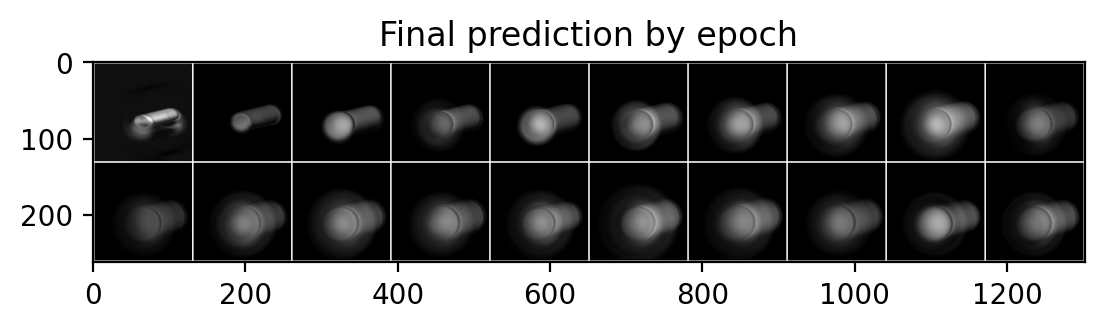

In [82]:
plt.imshow(
    torchvision.utils.make_grid(output_states, nrow=10, normalize=True, pad_value=1).permute(1,2,0)
)
plt.title("Final prediction by epoch")

In [84]:
blob, blob_tensor, _, _, final_state, video_id = traindata.__getitem__(2)
video_id

6

Text(0.5, 1.0, 'Blob state over time')

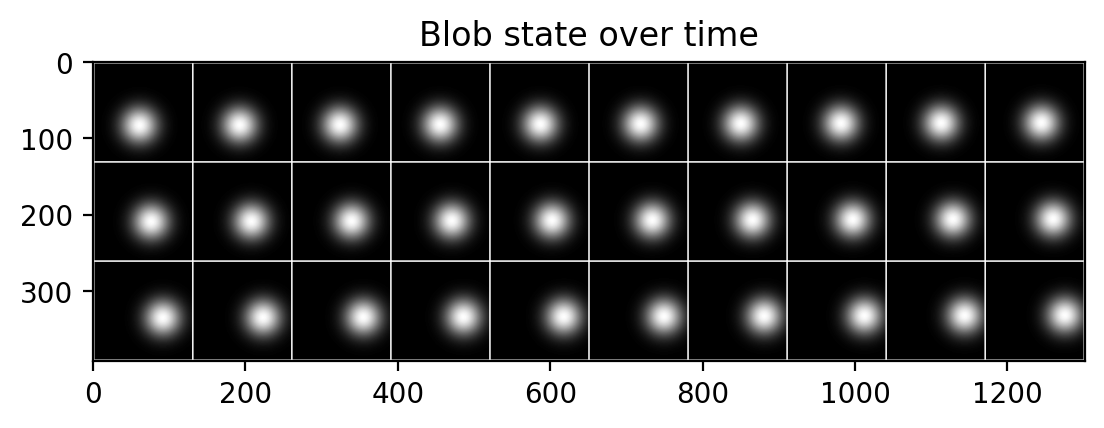

In [85]:
plt.imshow(
    torchvision.utils.make_grid(blob, nrow=10, normalize=True, pad_value=1).permute(1,2,0)
)
plt.title("Blob state over time")

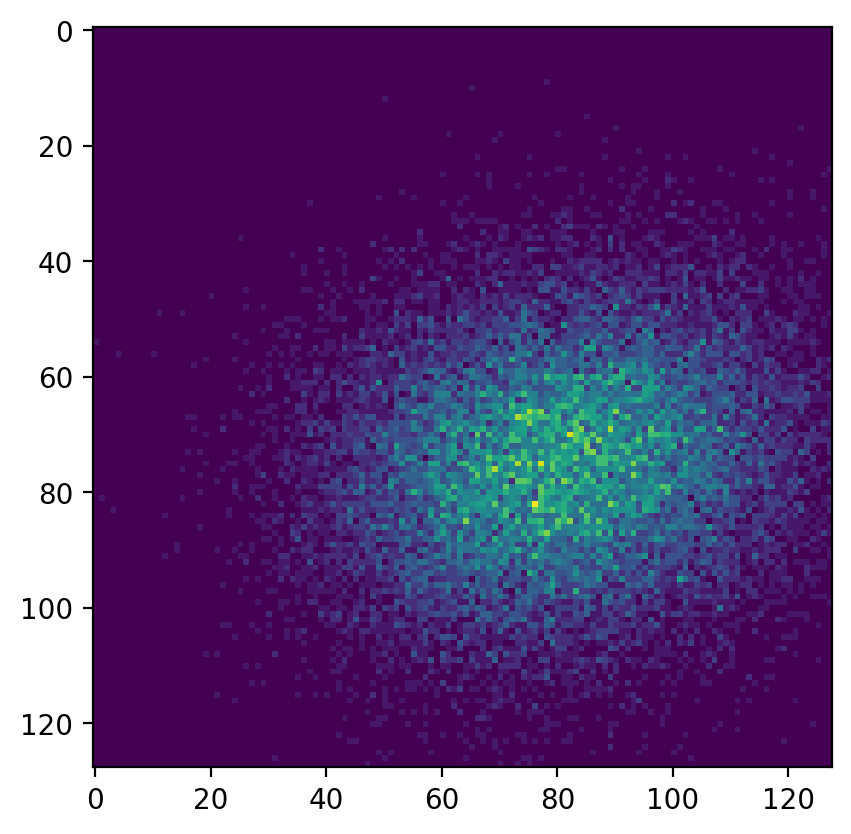

In [86]:
plt.imshow(final_state.permute(1,2,0))

In [87]:
prediction, stem_result, encoding, upsample, output_video, avgpool = net(torch.unsqueeze(blob_tensor,0).to('cuda'))

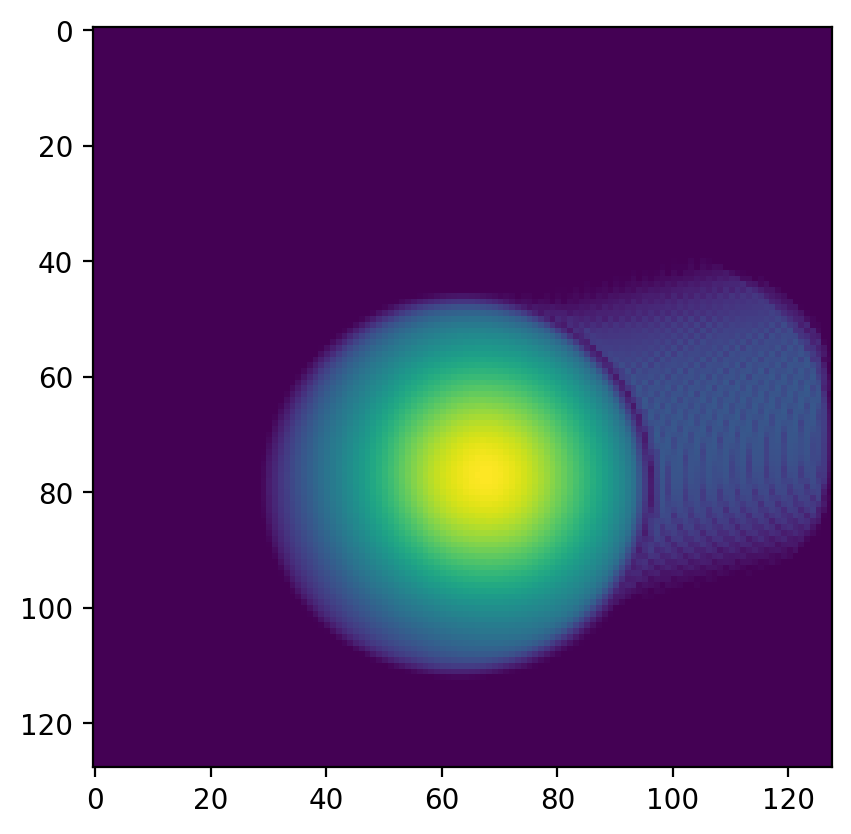

In [88]:
plt.imshow(torch.squeeze(prediction,0).cpu().detach().permute(1,2,0))

In [89]:
def test():
    # net.eval()
    testdata = CustomVideoDataset(
        file_df.query("train == 0"), VIDEO_DIR, transform_img
    )
    test_dataloader  = DataLoader(testdata,  batch_size=12, shuffle=True)

    blob, blob_tensor, claims, claims_tensor, final_state, video_id  = next(iter(test_dataloader))

    blob_tensor = blob_tensor.to("cuda")
    final_state = final_state.to("cuda")
    output_tensor, _, _, _, _, _ = net(blob_tensor)
    output_tensor = output_tensor.cpu().detach()

    print(output_tensor.shape)
    print(output_tensor.max())
    return final_state, output_tensor

final_state, output_tensor = test()
gc.collect()
torch.cuda.empty_cache()

torch.Size([12, 1, 128, 128])
tensor(0.0465)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


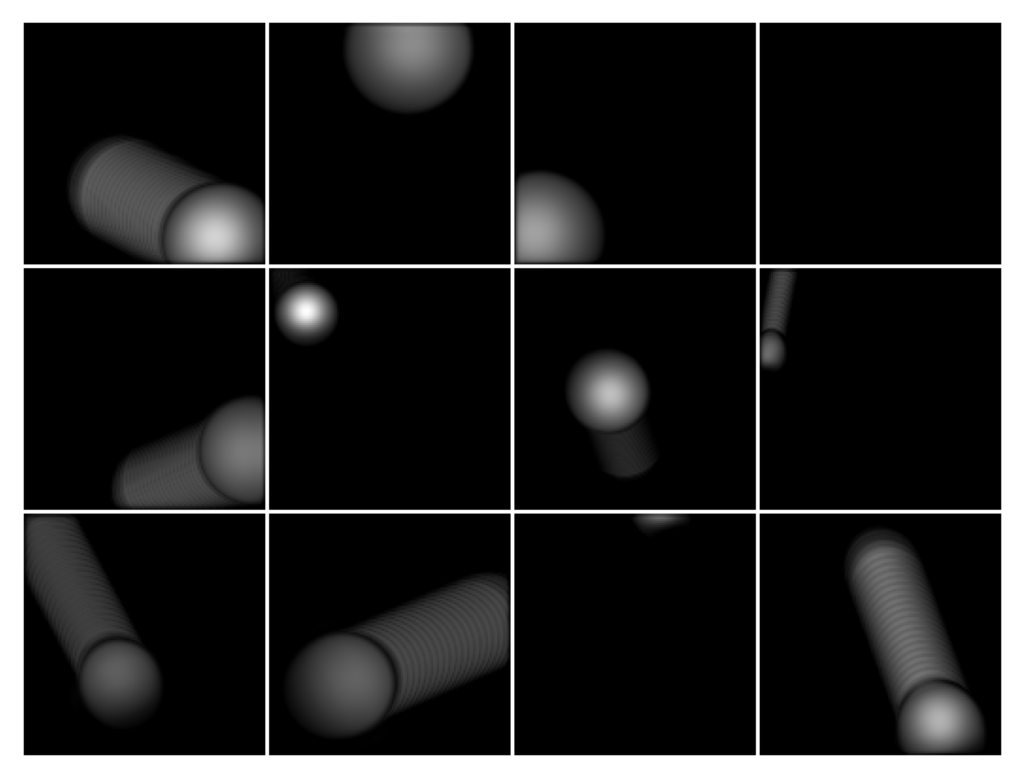

In [90]:
plt.imshow(
    torchvision.utils.make_grid(output_tensor, nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


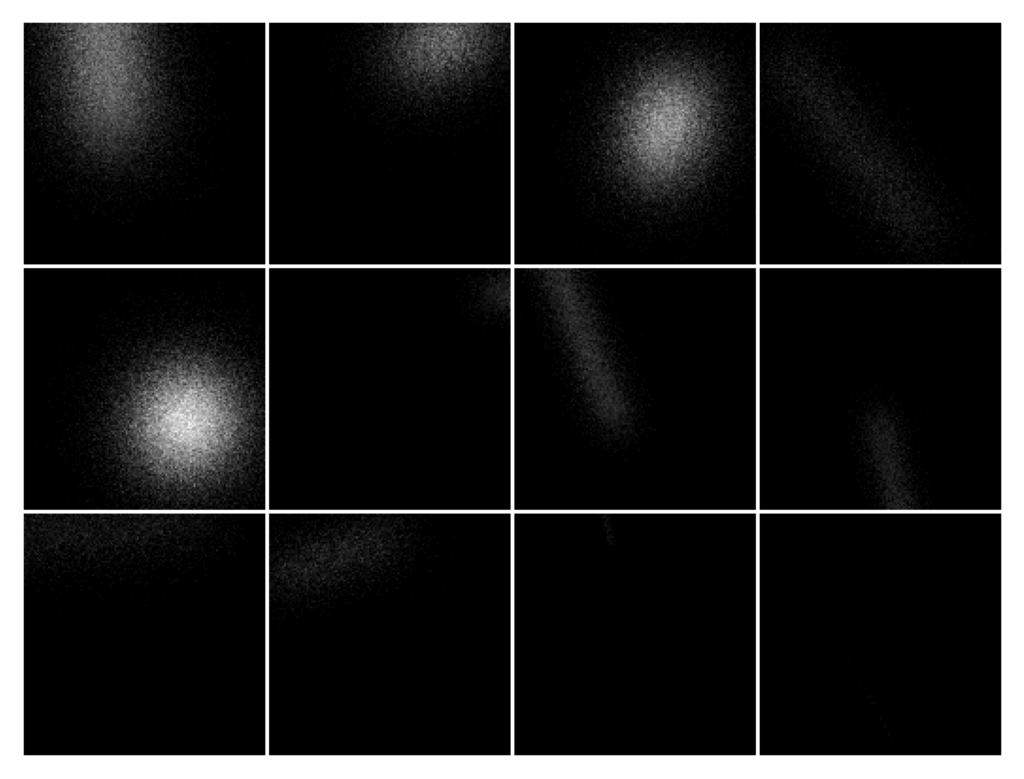

In [79]:
plt.imshow(
    torchvision.utils.make_grid(final_state.cpu().detach(), nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

In [80]:
print((final_state * 255).sum())
print((output_tensor * 255).sum())

tensor(166750., device='cuda:0')
tensor(121733.2109)
